In [1]:
import geopandas as gpd
import numpy as np

# ============================================================
# LOAD FACILITY FILE
# ============================================================

gdf = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_damage_scenarios_evt.geojson"
).to_crs(epsg=4326)

print("Loaded facilities:", len(gdf))

# ============================================================
# 1. DRAINAGE PROXIMITY FACTOR (closer = wetter)
# ============================================================

# Invert & normalize distance to drainage
gdf["wet_drainage"] = 1 - (
    gdf["dist_to_drainage_m"] - gdf["dist_to_drainage_m"].min()
) / (
    gdf["dist_to_drainage_m"].max() - gdf["dist_to_drainage_m"].min()
)

# ============================================================
# 2. ELEVATION FACTOR (lower = wetter)
# ============================================================

# Use percentile (already computed)
gdf["wet_elevation"] = 1 - gdf["elev_percentile"]

# ============================================================
# 3. SLOPE FACTOR (flatter = wetter)
# ============================================================

gdf["wet_slope"] = 1 - gdf["slope_percentile"]

# ============================================================
# 4. TOTAL WETNESS / FLOOD SUSCEPTIBILITY INDEX
# ============================================================

gdf["flood_susceptibility_index"] = (
    0.40 * gdf["wet_drainage"] +
    0.35 * gdf["wet_elevation"] +
    0.25 * gdf["wet_slope"]
)

# Clip safety
gdf["flood_susceptibility_index"] = gdf["flood_susceptibility_index"].clip(0, 1)

# ============================================================
# 5. CLASSIFICATION (for consultants / policy)
# ============================================================

def wetness_class(v):
    if v < 0.33:
        return "Low"
    elif v < 0.66:
        return "Moderate"
    else:
        return "High"

gdf["flood_susceptibility_class"] = (
    gdf["flood_susceptibility_index"].apply(wetness_class)
)

# ============================================================
# SAVE OUTPUT
# ============================================================

out_path = (
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_flood_susceptibility.geojson"
)

gdf.to_file(out_path, driver="GeoJSON")

print("Saved Flood Susceptibility Index to:")
print(out_path)

# ============================================================
# QUICK SANITY CHECK
# ============================================================

print("\nFlood Susceptibility Summary:")
print(gdf["flood_susceptibility_index"].describe())

print("\nClass counts:")
print(gdf["flood_susceptibility_class"].value_counts())


Loaded facilities: 16
Saved Flood Susceptibility Index to:
/vol/sandeep_storage/Files2/catastrophe/osm/waste_facilities_flood_susceptibility.geojson

Flood Susceptibility Summary:
count    16.000000
mean      0.536031
std       0.151617
min       0.250000
25%       0.459907
50%       0.499478
75%       0.629625
max       0.808425
Name: flood_susceptibility_index, dtype: float64

Class counts:
flood_susceptibility_class
Moderate    11
High         4
Low          1
Name: count, dtype: int64


Loaded facilities: 16


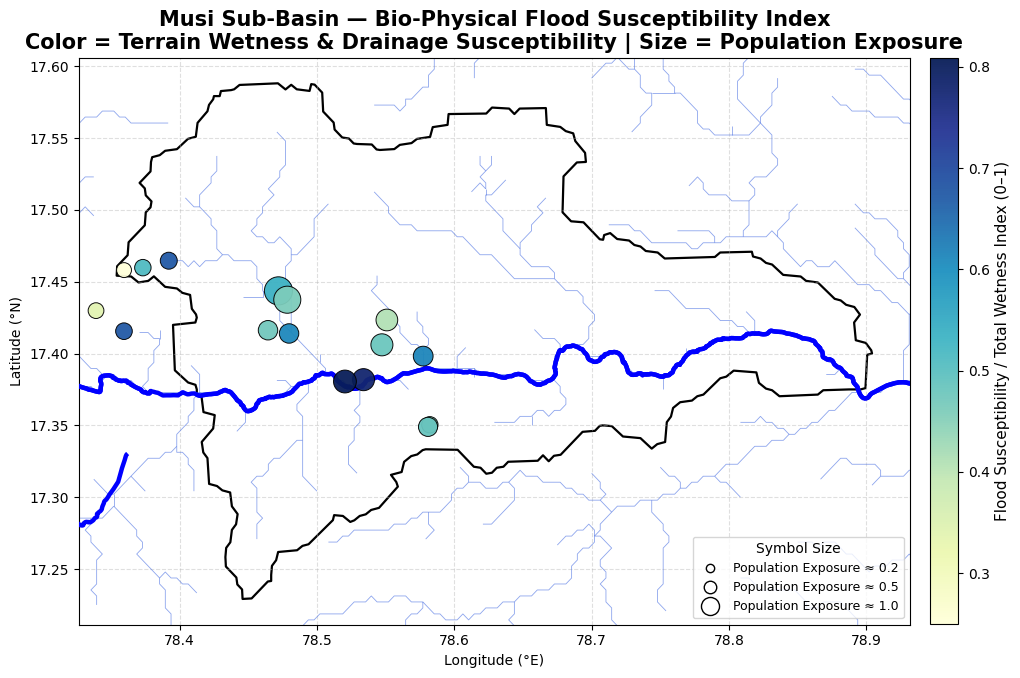

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

# ============================================================
# LOAD FLOOD SUSCEPTIBILITY (BIO-PHYSICAL)
# ============================================================

sus = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_flood_susceptibility.geojson"
).to_crs(epsg=4326)

# ============================================================
# LOAD POPULATION EXPOSURE (FROM HAZARD FILE)
# ============================================================

pop = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_flood_hazard_with_population.geojson"
).to_crs(epsg=4326)

# ------------------------------------------------------------
# SAFETY CHECK
# ------------------------------------------------------------
assert "pop_exposure" in pop.columns, "pop_exposure missing!"

# ============================================================
# MERGE POPULATION INTO SUSCEPTIBILITY FILE
# (Index-based merge is valid — same facilities, same order)
# ============================================================

sus["pop_exposure"] = pop["pop_exposure"].values

print("Loaded facilities:", len(sus))

# ============================================================
# LOAD BASE MAP LAYERS
# ============================================================

basin = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrobasin_08/"
    "musi_basin.shp"
).to_crs(epsg=4326)

rivers = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrorivers/"
    "hydrorivers_clean.geojson"
).to_crs(epsg=4326)

musi = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrorivers/"
    "musi.geojson"
).to_crs(epsg=4326)

# ============================================================
# MAP EXTENT
# ============================================================

minx, miny, maxx, maxy = basin.total_bounds
pad_x = 0.05 * (maxx - minx)
pad_y = 0.05 * (maxy - miny)

# ============================================================
# FIGURE
# ============================================================

fig, ax = plt.subplots(figsize=(11, 9))

# Basin boundary
basin.boundary.plot(ax=ax, linewidth=1.6, edgecolor="black", zorder=1)

# Rivers
rivers.plot(ax=ax, color="royalblue", linewidth=0.6, alpha=0.6, zorder=2)

# Musi river
musi.plot(ax=ax, color="blue", linewidth=3.2, zorder=3)

# ============================================================
# FACILITY POINTS
# Color → Flood susceptibility
# Size  → Population exposure
# ============================================================

norm = mpl.colors.Normalize(
    vmin=sus["flood_susceptibility_index"].min(),
    vmax=sus["flood_susceptibility_index"].max()
)

sc = ax.scatter(
    sus.geometry.x,
    sus.geometry.y,
    c=sus["flood_susceptibility_index"],
    cmap="YlGnBu",
    norm=norm,
    s=60 + 350 * sus["pop_exposure"],
    edgecolor="black",
    linewidth=0.7,
    alpha=0.95,
    zorder=4
)

# ============================================================
# COLORBAR
# ============================================================

cbar = plt.colorbar(sc, ax=ax, shrink=0.65, pad=0.02)
cbar.set_label(
    "Flood Susceptibility / Total Wetness Index (0–1)",
    fontsize=11
)

# ============================================================
# POPULATION SIZE LEGEND
# ============================================================

size_vals = [0.2, 0.5, 1.0]
size_markers = [6, 9, 13]

legend_handles = [
    Line2D(
        [0], [0],
        marker="o",
        linestyle="",
        markersize=ms,
        markerfacecolor="none",
        markeredgecolor="black",
        label=f"Population Exposure ≈ {val}"
    )
    for val, ms in zip(size_vals, size_markers)
]

ax.legend(
    handles=legend_handles,
    title="Symbol Size",
    loc="lower right",
    frameon=True,
    fontsize=9
)

# ============================================================
# AXES & TITLE
# ============================================================

ax.set_xlim(minx - pad_x, maxx + pad_x)
ax.set_ylim(miny - pad_y, maxy + pad_y)

ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.grid(True, linestyle="--", alpha=0.4)

ax.set_title(
    "Musi Sub-Basin — Bio-Physical Flood Susceptibility Index\n"
    "Color = Terrain Wetness & Drainage Susceptibility | Size = Population Exposure",
    fontsize=15,
    weight="bold"
)

plt.tight_layout()
plt.show()


In [4]:
import geopandas as gpd
import numpy as np

# ============================================================
# LOAD POPULATION-AWARE FACILITY FILE  (REFERENCE FROM BLOCK 2)
# ============================================================

gdf = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_flood_hazard_with_population.geojson"
).to_crs(epsg=4326)

print("Loaded facilities:", len(gdf))

# Sanity
assert "pop_exposure" in gdf.columns, "pop_exposure missing!"
assert "facility_type" in gdf.columns, "facility_type missing!"

# ============================================================
# SERVICE CRITICALITY WEIGHTS
# ============================================================

SERVICE_WEIGHT = {
    "wastewater_plant": 1.0,   # city-scale sanitation failure
    "transfer_station": 0.7,
    "landfill": 0.6,
    "recycling": 0.4,
    "other": 0.5
}

gdf["service_criticality"] = (
    gdf["facility_type"]
    .map(SERVICE_WEIGHT)
    .fillna(0.5)
)

# ============================================================
# SOCIO-ECONOMIC EXPOSURE INDEX
# ============================================================

# Raw index
gdf["socio_economic_exposure_raw"] = (
    gdf["pop_exposure"] * gdf["service_criticality"]
)

# Normalize to [0, 1]
gdf["socio_economic_exposure"] = (
    gdf["socio_economic_exposure_raw"]
    - gdf["socio_economic_exposure_raw"].min()
) / (
    gdf["socio_economic_exposure_raw"].max()
    - gdf["socio_economic_exposure_raw"].min()
)

# ============================================================
# CLASSIFICATION (POLICY / CONSULTANT FRIENDLY)
# ============================================================

def socio_class(v):
    if v < 0.33:
        return "Low"
    elif v < 0.66:
        return "Moderate"
    else:
        return "High"

gdf["socio_exposure_class"] = (
    gdf["socio_economic_exposure"].apply(socio_class)
)

# ============================================================
# SAVE OUTPUT
# ============================================================

out_path = (
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_socio_economic_exposure.geojson"
)

gdf.to_file(out_path, driver="GeoJSON")

print("\nSaved Socio-Economic Exposure Index to:")
print(out_path)

# ============================================================
# SANITY CHECKS
# ============================================================

print("\nSocio-Economic Exposure Summary:")
print(gdf["socio_economic_exposure"].describe())

print("\nClass distribution:")
print(gdf["socio_exposure_class"].value_counts())


Loaded facilities: 16

Saved Socio-Economic Exposure Index to:
/vol/sandeep_storage/Files2/catastrophe/osm/waste_facilities_socio_economic_exposure.geojson

Socio-Economic Exposure Summary:
count    16.000000
mean      0.314276
std       0.309246
min       0.000000
25%       0.065555
50%       0.225938
75%       0.477412
max       1.000000
Name: socio_economic_exposure, dtype: float64

Class distribution:
socio_exposure_class
Low         10
Moderate     4
High         2
Name: count, dtype: int64


Loaded facilities: 16


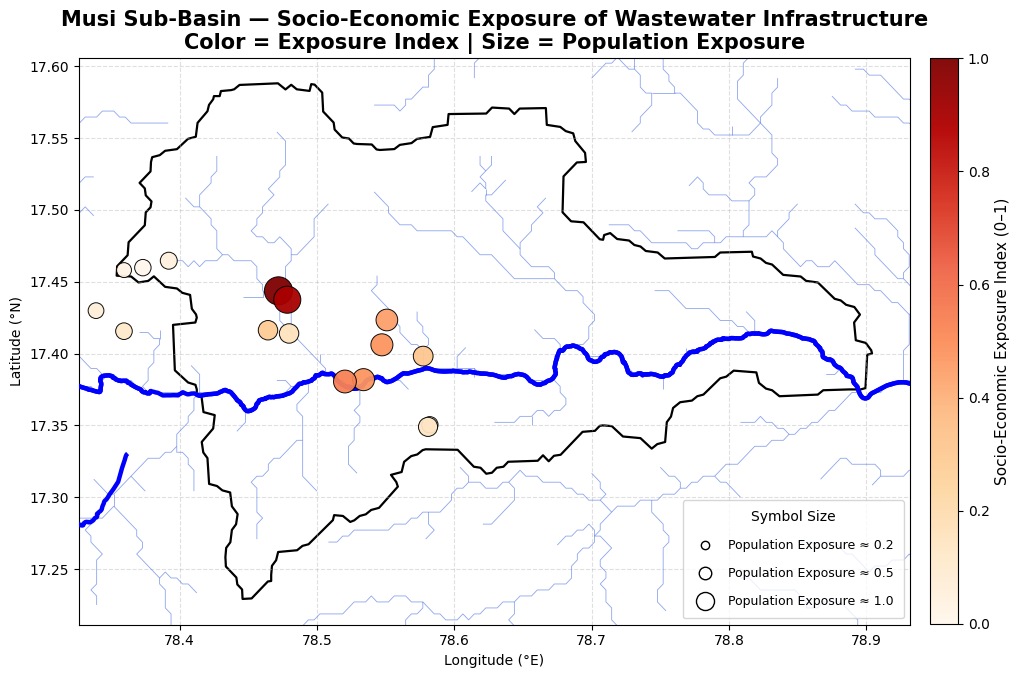

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

# ============================================================
# LOAD DATA
# ============================================================

fac = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_socio_economic_exposure.geojson"
).to_crs(epsg=4326)

basin = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrobasin_08/"
    "musi_basin.shp"
).to_crs(epsg=4326)

rivers = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrorivers/"
    "hydrorivers_clean.geojson"
).to_crs(epsg=4326)

musi = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrorivers/"
    "musi.geojson"
).to_crs(epsg=4326)

print("Loaded facilities:", len(fac))

# ============================================================
# MAP EXTENT
# ============================================================

minx, miny, maxx, maxy = basin.total_bounds
pad_x = 0.05 * (maxx - minx)
pad_y = 0.05 * (maxy - miny)

# ============================================================
# FIGURE
# ============================================================

fig, ax = plt.subplots(figsize=(11, 9))

# Basin boundary
basin.boundary.plot(
    ax=ax,
    linewidth=1.6,
    edgecolor="black",
    zorder=1
)

# River network
rivers.plot(
    ax=ax,
    color="royalblue",
    linewidth=0.6,
    alpha=0.6,
    zorder=2
)

# Musi river highlight
musi.plot(
    ax=ax,
    color="blue",
    linewidth=3.2,
    zorder=3,
    label="Musi River"
)

# ============================================================
# FACILITY POINTS
# Color → socio-economic exposure
# Size  → population exposure
# ============================================================

norm = mpl.colors.Normalize(
    vmin=fac["socio_economic_exposure"].min(),
    vmax=fac["socio_economic_exposure"].max()
)

sc = ax.scatter(
    fac.geometry.x,
    fac.geometry.y,
    c=fac["socio_economic_exposure"],
    cmap="OrRd",
    norm=norm,
    s=60 + 350 * fac["pop_exposure"],   # <-- size encoding added
    edgecolor="black",
    linewidth=0.7,
    alpha=0.95,
    zorder=4
)

# ============================================================
# COLORBAR
# ============================================================

cbar = plt.colorbar(sc, ax=ax, shrink=0.65, pad=0.02)
cbar.set_label(
    "Socio-Economic Exposure Index (0–1)",
    fontsize=11
)

# ============================================================
# POPULATION SIZE LEGEND
# ============================================================

size_vals = [0.2, 0.5, 1.0]
size_markers = [6, 9, 13]

legend_handles = [
    Line2D(
        [0], [0],
        marker="o",
        linestyle="",
        markersize=ms,
        markerfacecolor="none",
        markeredgecolor="black",
        label=f"Population Exposure ≈ {val}"
    )
    for val, ms in zip(size_vals, size_markers)
]

ax.legend(
    handles=legend_handles,
    title="Symbol Size",
    loc="lower right",
    frameon=True,
    fontsize=9,
    labelspacing=1.2,
    borderpad=0.8
)

# ============================================================
# AXES & TITLE
# ============================================================

ax.set_xlim(minx - pad_x, maxx + pad_x)
ax.set_ylim(miny - pad_y, maxy + pad_y)

ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.grid(True, linestyle="--", alpha=0.4)

ax.set_title(
    "Musi Sub-Basin — Socio-Economic Exposure of Wastewater Infrastructure\n"
    "Color = Exposure Index | Size = Population Exposure",
    fontsize=15,
    weight="bold"
)

plt.tight_layout()
plt.show()


In [6]:
import geopandas as gpd
import numpy as np

# ============================================================
# LOAD INPUT (FROM INDEX 2 OUTPUT)
# ============================================================

gdf = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_socio_economic_exposure.geojson"
).to_crs(epsg=4326)

print("Loaded facilities:", len(gdf))

# ============================================================
# 1. INSTITUTIONAL CAPACITY (FACILITY TYPE)
# ============================================================

INSTITUTIONAL_SCORE = {
    "wastewater_plant": 1.0,   # staffed, regulated, monitored
    "landfill": 0.7,
    "transfer_station": 0.6,
    "recycling": 0.5,
    "other": 0.5
}

gdf["institutional_capacity"] = (
    gdf["facility_type"].map(INSTITUTIONAL_SCORE).fillna(0.5)
)

# ============================================================
# 2. PHYSICAL ROBUSTNESS
# ============================================================

# Higher elevation + safer slope = higher coping ability
gdf["physical_robustness"] = (
    0.6 * gdf["elev_percentile"] +
    0.4 * (1 - gdf["slope_percentile"])
)

# ============================================================
# 3. ACCESSIBILITY / RESPONSE FEASIBILITY
# ============================================================

# Reuse drainage vulnerability inversely
gdf["accessibility_capacity"] = 1 - gdf["vuln_drainage"]

# ============================================================
# 4. POPULATION PRESSURE (INVERSE)
# ============================================================

gdf["population_buffer"] = 1 - gdf["pop_exposure"]

# ============================================================
# 5. COMPOSITE ADAPTIVE CAPACITY INDEX
# ============================================================

gdf["adaptive_capacity"] = (
    0.35 * gdf["institutional_capacity"] +
    0.30 * gdf["physical_robustness"] +
    0.20 * gdf["accessibility_capacity"] +
    0.15 * gdf["population_buffer"]
)

# Normalize to [0,1]
gdf["adaptive_capacity"] = (
    gdf["adaptive_capacity"] - gdf["adaptive_capacity"].min()
) / (
    gdf["adaptive_capacity"].max() - gdf["adaptive_capacity"].min()
)

# ============================================================
# CLASSIFICATION (POLICY FRIENDLY)
# ============================================================

def adaptive_class(v):
    if v < 0.33:
        return "Low"
    elif v < 0.66:
        return "Moderate"
    else:
        return "High"

gdf["adaptive_capacity_class"] = (
    gdf["adaptive_capacity"].apply(adaptive_class)
)

# ============================================================
# SAVE OUTPUT
# ============================================================

out_path = (
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_adaptive_capacity.geojson"
)

gdf.to_file(out_path, driver="GeoJSON")

print("\nSaved Adaptive Capacity Index:")
print(out_path)

# ============================================================
# SANITY CHECK
# ============================================================

print("\nAdaptive Capacity Summary:")
print(gdf["adaptive_capacity"].describe())

print("\nClass distribution:")
print(gdf["adaptive_capacity_class"].value_counts())


Loaded facilities: 16

Saved Adaptive Capacity Index:
/vol/sandeep_storage/Files2/catastrophe/osm/waste_facilities_adaptive_capacity.geojson

Adaptive Capacity Summary:
count    16.000000
mean      0.305148
std       0.293671
min       0.000000
25%       0.092127
50%       0.217175
75%       0.479511
max       1.000000
Name: adaptive_capacity, dtype: float64

Class distribution:
adaptive_capacity_class
Low         11
Moderate     3
High         2
Name: count, dtype: int64


Loaded facilities: 16


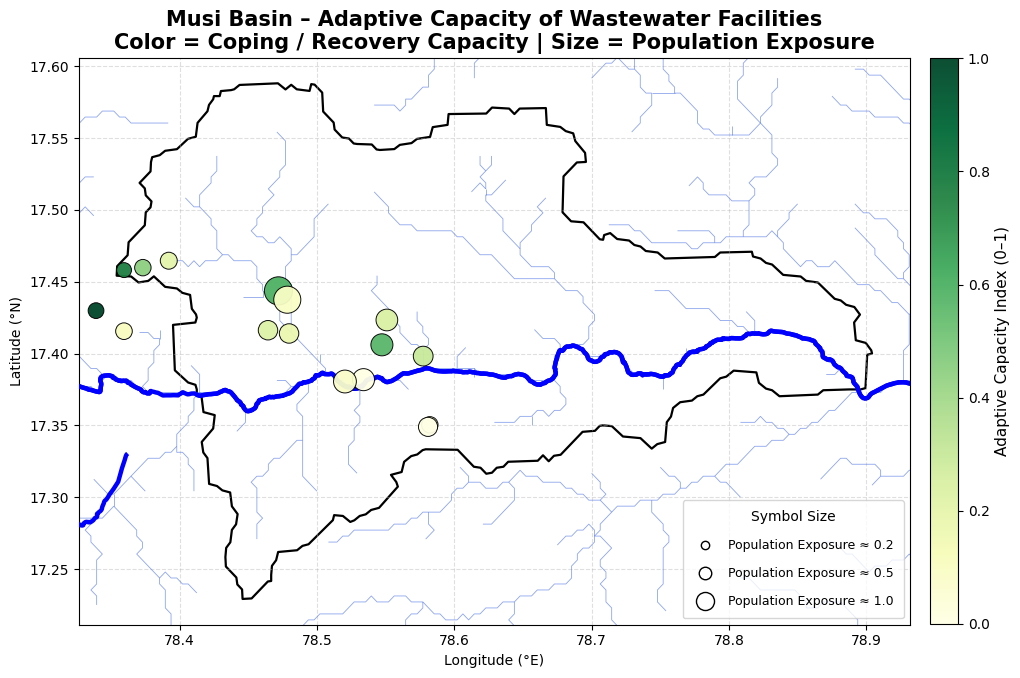

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

# ============================================================
# LOAD ADAPTIVE CAPACITY DATA
# ============================================================

waste = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_adaptive_capacity.geojson"
).to_crs(epsg=4326)

basin = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrobasin_08/"
    "musi_basin.shp"
).to_crs(epsg=4326)

rivers = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrorivers/"
    "hydrorivers_clean.geojson"
).to_crs(epsg=4326)

musi = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrorivers/"
    "musi.geojson"
).to_crs(epsg=4326)

print("Loaded facilities:", len(waste))

# ============================================================
# MAP EXTENT
# ============================================================

minx, miny, maxx, maxy = basin.total_bounds
pad_x = 0.05 * (maxx - minx)
pad_y = 0.05 * (maxy - miny)

extent = [
    minx - pad_x,
    maxx + pad_x,
    miny - pad_y,
    maxy + pad_y
]

# ============================================================
# FIGURE
# ============================================================

fig, ax = plt.subplots(figsize=(11, 9))

# Basin boundary
basin.boundary.plot(
    ax=ax,
    linewidth=1.6,
    edgecolor="black",
    zorder=1
)

# River network
rivers.plot(
    ax=ax,
    color="royalblue",
    linewidth=0.6,
    alpha=0.6,
    zorder=2
)

# Musi river
musi.plot(
    ax=ax,
    color="blue",
    linewidth=3.2,
    zorder=3,
    label="Musi River"
)

# ============================================================
# ADAPTIVE CAPACITY SCATTER
# ============================================================

norm = mpl.colors.Normalize(
    vmin=waste["adaptive_capacity"].min(),
    vmax=waste["adaptive_capacity"].max()
)

sc = ax.scatter(
    waste.geometry.x,
    waste.geometry.y,
    c=waste["adaptive_capacity"],
    cmap="YlGn",                     # higher = greener = better capacity
    norm=norm,
    s=60 + 350 * waste["pop_exposure"],
    edgecolor="black",
    linewidth=0.7,
    alpha=0.95,
    zorder=4
)

# ============================================================
# COLORBAR
# ============================================================

cbar = plt.colorbar(sc, ax=ax, shrink=0.65, pad=0.02)
cbar.set_label("Adaptive Capacity Index (0–1)", fontsize=11)

# ============================================================
# POPULATION SIZE LEGEND
# ============================================================

size_vals = [0.2, 0.5, 1.0]
size_markers = [6, 9, 13]

legend_handles = [
    Line2D(
        [0], [0],
        marker="o",
        linestyle="",
        markersize=ms,
        markerfacecolor="none",
        markeredgecolor="black",
        label=f"Population Exposure ≈ {val}"
    )
    for val, ms in zip(size_vals, size_markers)
]

ax.legend(
    handles=legend_handles,
    title="Symbol Size",
    loc="lower right",
    frameon=True,
    fontsize=9,
    labelspacing=1.2,
    borderpad=0.8
)

# ============================================================
# AXES & TITLE
# ============================================================

ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.grid(True, linestyle="--", alpha=0.4)

ax.set_title(
    "Musi Basin – Adaptive Capacity of Wastewater Facilities\n"
    "Color = Coping / Recovery Capacity | Size = Population Exposure",
    fontsize=15,
    weight="bold"
)

plt.tight_layout()
plt.show()


In [12]:
import geopandas as gpd
import numpy as np

# ============================================================
# LOAD INDEX FILES
# ============================================================

haz = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_flood_susceptibility.geojson"
).to_crs(epsg=4326)

soc = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_socio_economic_exposure.geojson"
).to_crs(epsg=4326)

cap = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_adaptive_capacity.geojson"
).to_crs(epsg=4326)

print("Loaded facilities:", len(haz))

# ============================================================
# ALIGN DATA (INDEX-BASED — SAFE IN YOUR PIPELINE)
# ============================================================

gdf = haz.copy()

gdf["hazard_index"] = haz["flood_susceptibility_index"]
gdf["exposure_index"] = soc["socio_economic_exposure"]
gdf["adaptive_capacity"] = cap["adaptive_capacity"]

# ============================================================
# COMPOSITE CLIMATE RISK INDEX (CCRI)
# ============================================================

gdf["composite_climate_risk"] = (
    gdf["hazard_index"]
    * gdf["exposure_index"]
    * (1 - gdf["adaptive_capacity"])
)

# ============================================================
# NORMALIZE CCRI TO [0,1]
# ============================================================

gdf["composite_climate_risk"] = (
    gdf["composite_climate_risk"]
    - gdf["composite_climate_risk"].min()
) / (
    gdf["composite_climate_risk"].max()
    - gdf["composite_climate_risk"].min()
)

# ============================================================
# POLICY-FRIENDLY CLASSIFICATION
# ============================================================

def risk_class(v):
    if v < 0.25:
        return "Low"
    elif v < 0.50:
        return "Moderate"
    elif v < 0.75:
        return "High"
    else:
        return "Critical"

gdf["composite_risk_class"] = (
    gdf["composite_climate_risk"].apply(risk_class)
)

# ============================================================
# SAVE OUTPUT
# ============================================================

out_path = (
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_composite_climate_risk.geojson"
)

gdf.to_file(out_path, driver="GeoJSON")

print("\nSaved Composite Climate Risk Index:")
print(out_path)

# ============================================================
# SANITY CHECKS
# ============================================================

print("\nComposite Risk Summary:")
print(gdf["composite_climate_risk"].describe())

print("\nRisk Class Distribution:")
print(gdf["composite_risk_class"].value_counts())


Loaded facilities: 16

Saved Composite Climate Risk Index:
/vol/sandeep_storage/Files2/catastrophe/osm/waste_facilities_composite_climate_risk.geojson

Composite Risk Summary:
count    16.000000
mean      0.327876
std       0.346482
min       0.000000
25%       0.051561
50%       0.223555
75%       0.399159
max       1.000000
Name: composite_climate_risk, dtype: float64

Risk Class Distribution:
composite_risk_class
Low         9
Moderate    3
Critical    3
High        1
Name: count, dtype: int64


Facilities loaded: 16
Population exposure added ✔


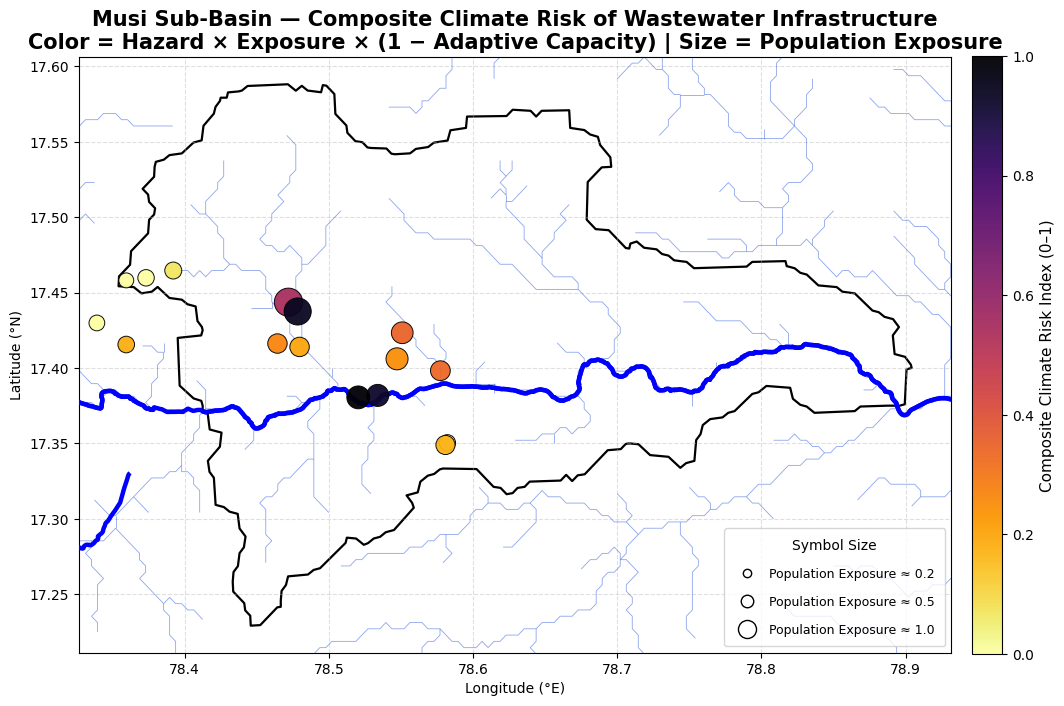

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

# ============================================================
# LOAD DATA
# ============================================================

# Composite risk (NO population here)
risk = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_composite_climate_risk.geojson"
).to_crs(epsg=4326)

# Population exposure source (AUTHORITATIVE)
pop = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_flood_hazard_with_population.geojson"
).to_crs(epsg=4326)

# Spatial context
basin = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrobasin_08/"
    "musi_basin.shp"
).to_crs(epsg=4326)

rivers = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrorivers/"
    "hydrorivers_clean.geojson"
).to_crs(epsg=4326)

musi = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrorivers/"
    "musi.geojson"
).to_crs(epsg=4326)

# ============================================================
# MERGE POPULATION EXPOSURE (INDEX-SAFE)
# ============================================================

assert len(risk) == len(pop), "Facility mismatch between risk and population files"

risk["pop_exposure"] = pop["pop_exposure"].values

print("Facilities loaded:", len(risk))
print("Population exposure added ✔")

# ============================================================
# MAP EXTENT
# ============================================================

minx, miny, maxx, maxy = basin.total_bounds
pad_x = 0.05 * (maxx - minx)
pad_y = 0.05 * (maxy - miny)

# ============================================================
# FIGURE
# ============================================================

fig, ax = plt.subplots(figsize=(11.5, 9.5))

# Basin boundary
basin.boundary.plot(
    ax=ax,
    linewidth=1.6,
    edgecolor="black",
    zorder=1
)

# River network
rivers.plot(
    ax=ax,
    color="royalblue",
    linewidth=0.6,
    alpha=0.6,
    zorder=2
)

# Musi river highlight
musi.plot(
    ax=ax,
    color="blue",
    linewidth=3.2,
    zorder=3,
    label="Musi River"
)

# ============================================================
# FACILITY POINTS
# Color → Composite Climate Risk
# Size  → Population Exposure
# ============================================================

norm = mpl.colors.Normalize(
    vmin=risk["composite_climate_risk"].min(),
    vmax=risk["composite_climate_risk"].max()
)

sc = ax.scatter(
    risk.geometry.x,
    risk.geometry.y,
    c=risk["composite_climate_risk"],
    cmap="inferno_r",
    norm=norm,
    s=60 + 350 * risk["pop_exposure"],
    edgecolor="black",
    linewidth=0.7,
    alpha=0.95,
    zorder=4
)

# ============================================================
# COLORBAR
# ============================================================

cbar = plt.colorbar(sc, ax=ax, shrink=0.65, pad=0.02)
cbar.set_label(
    "Composite Climate Risk Index (0–1)",
    fontsize=11
)

# ============================================================
# POPULATION SIZE LEGEND
# ============================================================

size_vals = [0.2, 0.5, 1.0]
size_markers = [6, 9, 13]

legend_handles = [
    Line2D(
        [0], [0],
        marker="o",
        linestyle="",
        markersize=ms,
        markerfacecolor="none",
        markeredgecolor="black",
        label=f"Population Exposure ≈ {val}"
    )
    for val, ms in zip(size_vals, size_markers)
]

ax.legend(
    handles=legend_handles,
    title="Symbol Size",
    loc="lower right",
    frameon=True,
    fontsize=9,
    labelspacing=1.2,
    borderpad=0.8
)

# ============================================================
# AXES & TITLE
# ============================================================

ax.set_xlim(minx - pad_x, maxx + pad_x)
ax.set_ylim(miny - pad_y, maxy + pad_y)

ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.grid(True, linestyle="--", alpha=0.4)

ax.set_title(
    "Musi Sub-Basin — Composite Climate Risk of Wastewater Infrastructure\n"
    "Color = Hazard × Exposure × (1 − Adaptive Capacity) | Size = Population Exposure",
    fontsize=15,
    weight="bold"
)

plt.tight_layout()
plt.show()


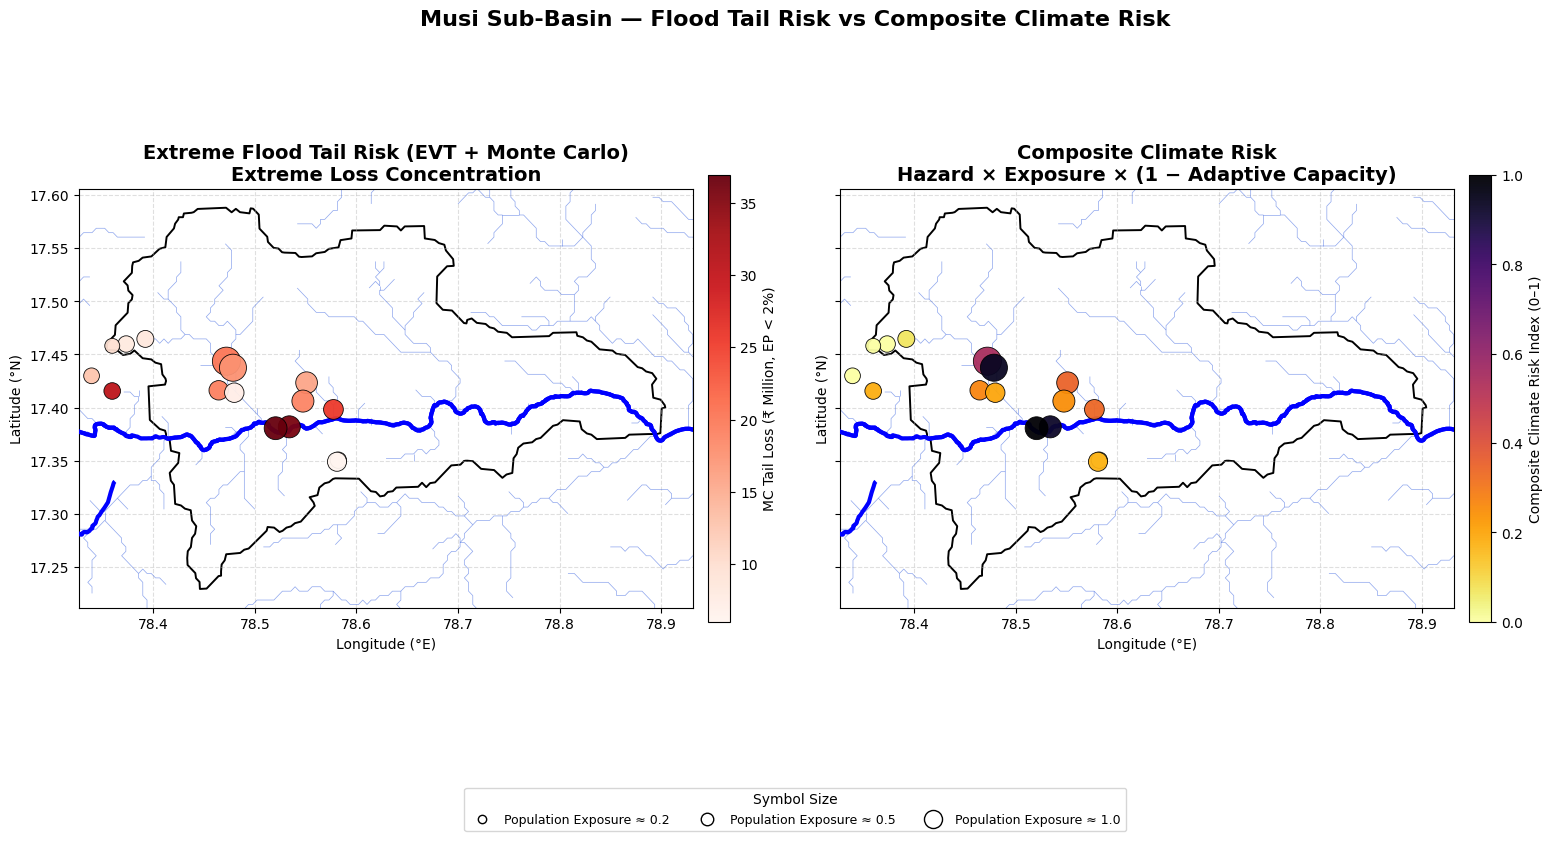

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

# ============================================================
# LOAD FACILITY RISK (EVT vs MC)
# ============================================================

risk = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/"
    "musi_facility_risk_classification_evt_vs_mc.geojson"
).to_crs(epsg=4326)

# ============================================================
# LOAD COMPOSITE CLIMATE RISK
# ============================================================

comp = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_composite_climate_risk.geojson"
).to_crs(epsg=4326)

# ============================================================
# LOAD POPULATION EXPOSURE
# ============================================================

pop = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_flood_hazard_with_population.geojson"
).to_crs(epsg=4326)

risk["pop_exposure"] = pop["pop_exposure"].values
comp["pop_exposure"] = pop["pop_exposure"].values

# ============================================================
# SPATIAL CONTEXT
# ============================================================

basin = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrobasin_08/musi_basin.shp"
).to_crs(epsg=4326)

rivers = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrorivers/hydrorivers_clean.geojson"
).to_crs(epsg=4326)

musi = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrorivers/musi.geojson"
).to_crs(epsg=4326)

# ============================================================
# MAP EXTENT
# ============================================================

minx, miny, maxx, maxy = basin.total_bounds
pad_x = 0.05 * (maxx - minx)
pad_y = 0.05 * (maxy - miny)

# ============================================================
# FIGURE
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 9), sharex=True, sharey=True)

# ============================================================
# PANEL 1 — MC TAIL FINANCIAL RISK
# ============================================================

ax = axes[0]

basin.boundary.plot(ax=ax, linewidth=1.4, edgecolor="black", zorder=1)
rivers.plot(ax=ax, color="royalblue", linewidth=0.5, alpha=0.6, zorder=2)
musi.plot(ax=ax, color="blue", linewidth=3.0, zorder=3)

sc1 = ax.scatter(
    risk.geometry.x,
    risk.geometry.y,
    c=risk["loss_mc_tail"] / 1e6,  # millions
    cmap="Reds",
    s=60 + 350 * risk["pop_exposure"],
    edgecolor="black",
    linewidth=0.6,
    alpha=0.95,
    zorder=4
)

cbar1 = plt.colorbar(sc1, ax=ax, shrink=0.55, pad=0.02)
cbar1.set_label("MC Tail Loss (₹ Million, EP < 2%)", fontsize=10)

cbar1.ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{int(x)}")
)

ax.set_title(
    "Extreme Flood Tail Risk (EVT + Monte Carlo)\n"
    "Extreme Loss Concentration",
    fontsize=14,
    weight="bold"
)

# ============================================================
# PANEL 2 — COMPOSITE CLIMATE RISK
# ============================================================

ax = axes[1]

basin.boundary.plot(ax=ax, linewidth=1.4, edgecolor="black", zorder=1)
rivers.plot(ax=ax, color="royalblue", linewidth=0.5, alpha=0.6, zorder=2)
musi.plot(ax=ax, color="blue", linewidth=3.0, zorder=3)

sc2 = ax.scatter(
    comp.geometry.x,
    comp.geometry.y,
    c=comp["composite_climate_risk"],
    cmap="inferno_r",
    s=60 + 350 * comp["pop_exposure"],
    edgecolor="black",
    linewidth=0.6,
    alpha=0.95,
    zorder=4
)

cbar2 = plt.colorbar(sc2, ax=ax, shrink=0.55, pad=0.02)
cbar2.set_label("Composite Climate Risk Index (0–1)", fontsize=10)

ax.set_title(
    "Composite Climate Risk\n"
    "Hazard × Exposure × (1 − Adaptive Capacity)",
    fontsize=14,
    weight="bold"
)

# ============================================================
# SHARED AXES
# ============================================================

for ax in axes:
    ax.set_xlim(minx - pad_x, maxx + pad_x)
    ax.set_ylim(miny - pad_y, maxy + pad_y)
    ax.set_xlabel("Longitude (°E)")
    ax.set_ylabel("Latitude (°N)")
    ax.grid(True, linestyle="--", alpha=0.4)

# ============================================================
# POPULATION SIZE LEGEND
# ============================================================

size_vals = [0.2, 0.5, 1.0]
size_markers = [6, 9, 13]

legend_handles = [
    Line2D(
        [0], [0],
        marker="o",
        linestyle="",
        markersize=ms,
        markerfacecolor="none",
        markeredgecolor="black",
        label=f"Population Exposure ≈ {val}"
    )
    for val, ms in zip(size_vals, size_markers)
]

fig.legend(
    handles=legend_handles,
    title="Symbol Size",
    loc="lower center",
    ncol=3,
    frameon=True,
    fontsize=9,
    bbox_to_anchor=(0.5, -0.02)
)

plt.suptitle(
    "Musi Sub-Basin — Flood Tail Risk vs Composite Climate Risk\n",
    fontsize=16,
    weight="bold",
    y=0.9
)

plt.tight_layout()
plt.show()


----

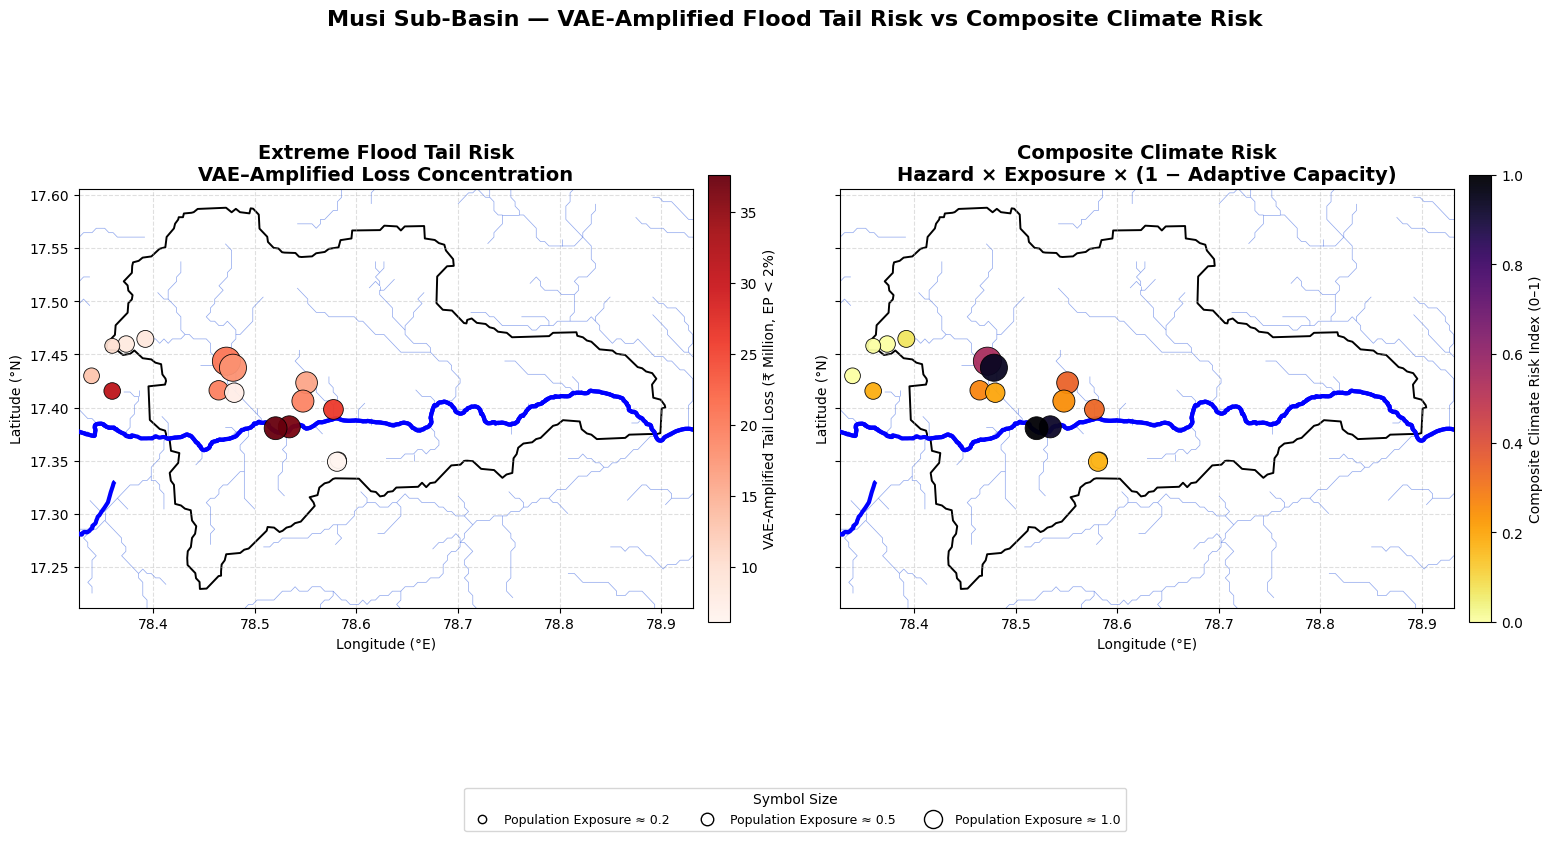

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

# ============================================================
# LOAD FACILITY RISK (EVT + MC + VAE)
# ============================================================

risk = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/"
    "musi_facility_risk_classification_evt_mc_vae.geojson"
).to_crs(epsg=4326)

# ============================================================
# LOAD COMPOSITE CLIMATE RISK
# ============================================================

comp = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_composite_climate_risk.geojson"
).to_crs(epsg=4326)

# ============================================================
# LOAD POPULATION EXPOSURE
# ============================================================

pop = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_flood_hazard_with_population.geojson"
).to_crs(epsg=4326)

risk["pop_exposure"] = pop["pop_exposure"].values
comp["pop_exposure"] = pop["pop_exposure"].values

# ============================================================
# SPATIAL CONTEXT
# ============================================================

basin = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrobasin_08/musi_basin.shp"
).to_crs(epsg=4326)

rivers = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrorivers/hydrorivers_clean.geojson"
).to_crs(epsg=4326)

musi = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrorivers/musi.geojson"
).to_crs(epsg=4326)

# ============================================================
# MAP EXTENT
# ============================================================

minx, miny, maxx, maxy = basin.total_bounds
pad_x = 0.05 * (maxx - minx)
pad_y = 0.05 * (maxy - miny)

# ============================================================
# FIGURE
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 9), sharex=True, sharey=True)

# ============================================================
# PANEL 1 — VAE-AMPLIFIED TAIL FINANCIAL RISK
# ============================================================

ax = axes[0]

basin.boundary.plot(ax=ax, linewidth=1.4, edgecolor="black", zorder=1)
rivers.plot(ax=ax, color="royalblue", linewidth=0.5, alpha=0.6, zorder=2)
musi.plot(ax=ax, color="blue", linewidth=3.0, zorder=3)

sc1 = ax.scatter(
    risk.geometry.x,
    risk.geometry.y,
    c=risk["loss_vae_tail"] / 1e6,   # millions
    cmap="Reds",
    s=60 + 350 * risk["pop_exposure"],
    edgecolor="black",
    linewidth=0.6,
    alpha=0.95,
    zorder=4
)

cbar1 = plt.colorbar(sc1, ax=ax, shrink=0.55, pad=0.02)
cbar1.set_label("VAE-Amplified Tail Loss (₹ Million, EP < 2%)", fontsize=10)

cbar1.ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{int(x)}")
)

ax.set_title(
    "Extreme Flood Tail Risk\n"
    "VAE–Amplified Loss Concentration",
    fontsize=14,
    weight="bold"
)

# ============================================================
# PANEL 2 — COMPOSITE CLIMATE RISK
# ============================================================

ax = axes[1]

basin.boundary.plot(ax=ax, linewidth=1.4, edgecolor="black", zorder=1)
rivers.plot(ax=ax, color="royalblue", linewidth=0.5, alpha=0.6, zorder=2)
musi.plot(ax=ax, color="blue", linewidth=3.0, zorder=3)

sc2 = ax.scatter(
    comp.geometry.x,
    comp.geometry.y,
    c=comp["composite_climate_risk"],
    cmap="inferno_r",
    s=60 + 350 * comp["pop_exposure"],
    edgecolor="black",
    linewidth=0.6,
    alpha=0.95,
    zorder=4
)

cbar2 = plt.colorbar(sc2, ax=ax, shrink=0.55, pad=0.02)
cbar2.set_label("Composite Climate Risk Index (0–1)", fontsize=10)

ax.set_title(
    "Composite Climate Risk\n"
    "Hazard × Exposure × (1 − Adaptive Capacity)",
    fontsize=14,
    weight="bold"
)

# ============================================================
# SHARED AXES
# ============================================================

for ax in axes:
    ax.set_xlim(minx - pad_x, maxx + pad_x)
    ax.set_ylim(miny - pad_y, maxy + pad_y)
    ax.set_xlabel("Longitude (°E)")
    ax.set_ylabel("Latitude (°N)")
    ax.grid(True, linestyle="--", alpha=0.4)

# ============================================================
# POPULATION SIZE LEGEND
# ============================================================

size_vals = [0.2, 0.5, 1.0]
size_markers = [6, 9, 13]

legend_handles = [
    Line2D(
        [0], [0],
        marker="o",
        linestyle="",
        markersize=ms,
        markerfacecolor="none",
        markeredgecolor="black",
        label=f"Population Exposure ≈ {val}"
    )
    for val, ms in zip(size_vals, size_markers)
]

fig.legend(
    handles=legend_handles,
    title="Symbol Size",
    loc="lower center",
    ncol=3,
    frameon=True,
    fontsize=9,
    bbox_to_anchor=(0.5, -0.02)
)

plt.suptitle(
    "Musi Sub-Basin — VAE-Amplified Flood Tail Risk vs Composite Climate Risk\n",
    fontsize=16,
    weight="bold",
    y=0.9
)

plt.tight_layout()
plt.show()
